In [1]:
# update the git
! git add  .
! git commit -m "From Mac"
! git push

[master 1772b4d9] From Mac
 2 files changed, 165 insertions(+), 125 deletions(-)
Counting objects: 7, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 75.16 KiB | 5.37 MiB/s, done.
Total 7 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 5 local objects.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   a15f4398..1772b4d9  master -> master


In [2]:
# import library
import tensorflow as tf
import matplotlib 
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [3]:
# get the fashion mnist data set
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((10000,28,28,1))
test_batch = np.zeros((10000,28,28,1))

for x in range(len(test_batch)):
    train_batch[x,:,:,:] = np.expand_dims(resize(x_data[x,:,:,0],(28,28)),axis=3)
# for x in range(len(y_data)):
#     test_batch[x,:,:,:] = np.expand_dims(resize(y_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  from ipykernel import kernelapp as app


(10000, 28, 28, 1)
1.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
0.0
0.0
(10000, 10)
1.0
0.0


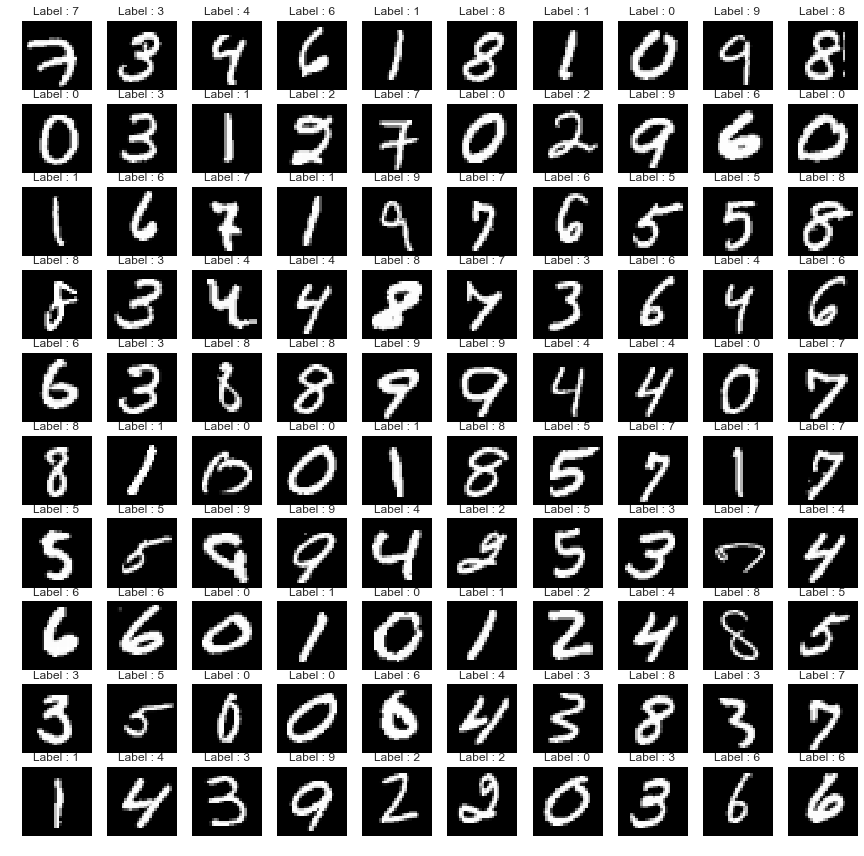

In [4]:
# show small amount of fashion
fig=plt.figure(figsize=(15, 15))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title("Label : "+str(np.argmax(train_label[i-1])))
plt.show()

In [14]:
# import all of the layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_relu(x): return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x): return x
def d_tf_iden(x): return 1.0

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class FNN():

    def __init__(self,inc,outc,stddev=0.05,act=tf_elu,d_act=d_tf_elu,special_init=False):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w  = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float32,seed=4))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w)
        self.layerA = self.act(self.layer)
        return self.layerA

    def feedforward_recover(self,input):
        self.input_re = input
        self.layer_re = tf.matmul(self.w,self.input_re)
        self.layerA_re = self.act(self.layer_re)
        return self.layerA_re

    def backprop(self,gradient=None,which_reg=0):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        if which_reg == 0:
            grad = grad

        if which_reg == 0.5:
            grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)

        if which_reg == 1:
            grad = grad + lamda * tf.sign(self.w)

        if which_reg == 1.5:
            grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w

        if which_reg == 2:
            grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)

        if which_reg == 2.5:
            grad = grad + lamda * 2.0 * self.w

        if which_reg == 3:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)

        if which_reg == 4:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        return grad_pass,update_w

class CNN():

    def __init__(self,k,inc,out,stddev=0.05,which_reg=0,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        ) / batch_size

        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        )

        if self.which_reg == 0:
            grad = grad

        if self.which_reg == 0.5:
            grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)

        if self.which_reg == 1:
            grad = grad + lamda * tf.sign(self.w)

        if self.which_reg == 1.5:
            grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w

        if self.which_reg == 2:
            grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)

        if self.which_reg == 2.5:
            grad = grad + lamda * 2.0 * self.w

        if self.which_reg == 3:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)

        if self.which_reg == 4:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

In [20]:
# hyper class
num_epoch = 20; learning_rate = 0.001 ; batch_size = 100; print_size = 2
lamda = 0.0
beta1,beta2,adam_e = 0.9,0.999,1e-8

e1 = CNN(3,1,8)
e2 = CNN(3,8,16)
latent_before = FNN(5*5*16,2)
latent_after  = FNN(2,7*7*16)
d1 = CNN(3,16,8)
d2 = CNN(3,8,1,act=tf_sigmoid,d_act=d_tf_sigmoid)

In [28]:
# encoding/decoding (feed forward)
x = tf.placeholder(shape=[batch_size,28,28,1],dtype=tf.float32)

elayer1 = e1.feedforward(x)
elayer1_pool = tf.nn.avg_pool(elayer1,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')
elayer2 = e2.feedforward(elayer1_pool)
elayer2_pool = tf.nn.avg_pool(elayer2,strides=[1,2,2,1],ksize=[1,2,2,1],padding='VALID')

elayer2_reshape = tf.reshape(elayer2_pool,[batch_size,-1])
latent_layer  = latent_before.feedforward(elayer2_reshape)
recover_latent= latent_after.feedforward(latent_layer)
recover_reshape = tf.reshape(recover_latent,[batch_size,7,7,elayer2_pool.shape[3].value])

dlayer1_uppool = tf.image.resize_bilinear(recover_reshape,[16,16])
dlayer1 = d1.feedforward(dlayer1_uppool)
dlayer2_uppool = tf.image.resize_bilinear(dlayer1,[30,30])
dlayer2 = d2.feedforward(dlayer2_uppool)

print(elayer1,elayer1_pool)
print(elayer2,elayer2_pool)

print(elayer2_reshape,latent_layer)
print(recover_latent,recover_reshape)
print(dlayer1,dlayer1_uppool)
print(dlayer2,dlayer2_uppool)

Tensor("Elu_57:0", shape=(100, 26, 26, 8), dtype=float32) Tensor("AvgPool_26:0", shape=(100, 13, 13, 8), dtype=float32)
Tensor("Elu_58:0", shape=(100, 11, 11, 16), dtype=float32) Tensor("AvgPool_27:0", shape=(100, 5, 5, 16), dtype=float32)
Tensor("Reshape_22:0", shape=(100, 400), dtype=float32) Tensor("Elu_59:0", shape=(100, 2), dtype=float32)
Tensor("Elu_60:0", shape=(100, 784), dtype=float32) Tensor("Reshape_23:0", shape=(100, 7, 7, 16), dtype=float32)
Tensor("Elu_61:0", shape=(100, 14, 14, 8), dtype=float32) Tensor("ResizeBilinear_16:0", shape=(100, 16, 16, 16), dtype=float32)
Tensor("Sigmoid_7:0", shape=(100, 28, 28, 1), dtype=float32) Tensor("ResizeBilinear_17:0", shape=(100, 30, 30, 8), dtype=float32)


In [32]:
# encoding / decoding (back prop)
recon_cost = tf.reduce_mean(tf.square(dlayer2-x))
total_cost = recon_cost 

recon_grad = dlayer2-x
total_grad = (recon_grad)/batch_size

dgrad2,dgrad2_up = d2.backprop(total_grad)
dgrad2_pool = tf.image.resize_bilinear(dgrad2,[14,14])
dgrad1,dgrad1_up = d1.backprop(dgrad2_pool)
dgrad1_pool = tf.image.resize_bilinear(dgrad1,[7,7])

dgrad1_reshape = tf.reshape(dgrad1_pool,[batch_size,-1])
dgrad_recover,dgrad_recover_up  = latent_after.backprop(dgrad1_reshape)
dgrad_latent ,dgrad_latent_up   = latent_before.backprop(dgrad_recover)
dgrad_latent_reshape = tf.reshape(dgrad_latent,[batch_size,5,5,elayer2_pool.shape[3].value])

egrad2_pool = tf.image.resize_bilinear(dgrad_latent_reshape,[11,11])
egrad2,egrad2_up = e2.backprop(egrad2_pool)
egrad1_pool = tf.image.resize_bilinear(egrad2,[26,26])
egrad1,egrad1_up = e1.backprop(egrad1_pool)

grad_update = dgrad2_up + dgrad1_up + dgrad_recover_up + dgrad_latent_up + egrad2_up + egrad1_up

print(dgrad2_pool,dgrad2)
print(dgrad1_pool,dgrad1)
print(dgrad1_reshape)
print(dgrad_latent)
print(dgrad_latent_reshape)
print(egrad2_pool,egrad2)
print(egrad1_pool,egrad1)

Tensor("ResizeBilinear_27:0", shape=(100, 14, 14, 8), dtype=float32) Tensor("Conv2DBackpropInput_15:0", shape=(100, 30, 30, 8), dtype=float32)
Tensor("ResizeBilinear_28:0", shape=(100, 7, 7, 16), dtype=float32) Tensor("Conv2DBackpropInput_16:0", shape=(100, 16, 16, 16), dtype=float32)
Tensor("Reshape_30:0", shape=(100, 784), dtype=float32)
Tensor("MatMul_44:0", shape=(100, 400), dtype=float32)
Tensor("Reshape_31:0", shape=(100, 5, 5, 16), dtype=float32)
Tensor("ResizeBilinear_29:0", shape=(100, 11, 11, 16), dtype=float32) Tensor("Conv2DBackpropInput_17:0", shape=(100, 13, 13, 8), dtype=float32)
Tensor("ResizeBilinear_30:0", shape=(100, 26, 26, 8), dtype=float32) Tensor("Conv2DBackpropInput_18:0", shape=(100, 28, 28, 1), dtype=float32)


 iter: 0 batch: 9900 cost: 0.061395325

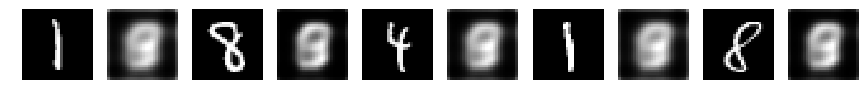

 iter: 2 batch: 9900 cost: 0.060943253

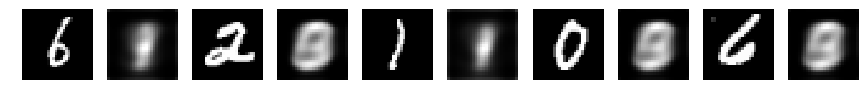

 iter: 4 batch: 9900 cost: 0.061386954

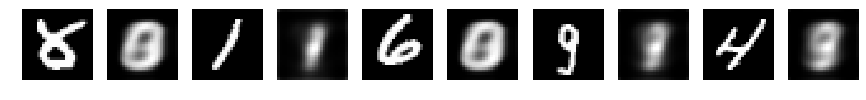

 iter: 6 batch: 9900 cost: 0.063495793

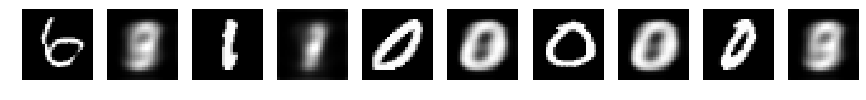

 iter: 8 batch: 9900 cost: 0.058308966

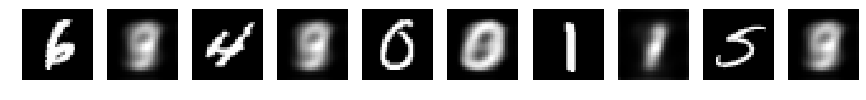

 iter: 10 batch: 9900 cost: 0.057906482

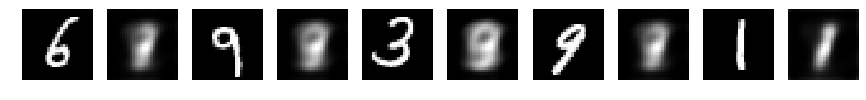

 iter: 12 batch: 9900 cost: 0.060475452

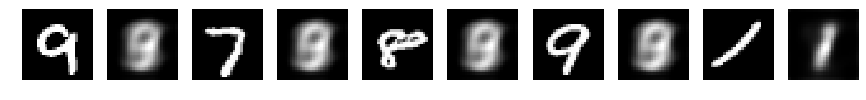

 iter: 14 batch: 9900 cost: 0.064201534

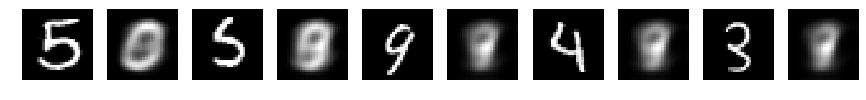

 iter: 16 batch: 9900 cost: 0.058032397

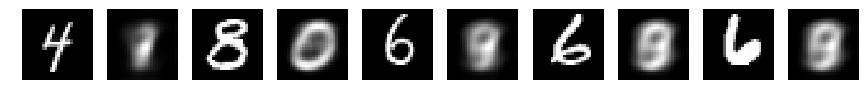

 iter: 18 batch: 9700 cost: 0.054950114

KeyboardInterrupt: 

In [13]:
# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_batch_shuffled = train_batch.copy()

for iter in range(num_epoch):
    
    for current_data_index in range(0,len(train_batch),batch_size):
        current_data = train_batch_shuffled[current_data_index:current_data_index+batch_size].astype(np.float32)
        sess_result = sess.run([total_cost,grad_update],feed_dict={x:current_data})
        sys.stdout.write(
            '\r iter: ' + str(iter) + ' batch: ' + str(current_data_index) + ' cost: ' + str(sess_result[0])
        )
        sys.stdout.flush()
        
    if iter % print_size == 0:
        sess_result = sess.run(dlayer2,feed_dict={x:current_data})
        fig=plt.figure(figsize=(15, 15))
        columns = 10 ; rows = 1
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            if i % 2 ==0 :
                  plt.imshow(np.squeeze(sess_result[i-2]),cmap='gray')
            else:
                plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
            plt.axis('off')
        plt.show()
        
        train_batch_shuffled = shuffle(train_batch_shuffled)

In [ ]:
# convert every data into latent to know the statistics
all_latent_vectors = []
print(train_batch.shape)
for current_batch_index in range(0,5000, batch_size):
    current_train_data = train_batch[current_batch_index:current_batch_index+batch_size]
    sess_results = sess.run(layer3,feed_dict={x:current_train_data})
    all_latent_vectors.append(sess_results)
all_latent_vectors = np.asarray(all_latent_vectors)
print(all_latent_vectors.shape)

In [ ]:
#  use high level apis to view the data
all_latent_vectors = all_latent_vectors.reshape(50*100,-1)
print(all_latent_vectors.shape)
from sklearn.decomposition import PCA
sk_pca = PCA(n_components=3)
sk_data = sk_pca.fit_transform(all_latent_vectors)
print(sk_data.shape)

In [ ]:
# create 3D graph from PCA
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
color_dict = {
    0:'red',
    1:'blue',
    2:'green',
    3:'yellow',
    4:'purple',
    5:'grey',
    6:'black',
    7:'violet',
    8:'silver',
    9:'cyan',
}
color_mapping = [color_dict[x] for x in np.argmax(train_label[:5000,:],1) ]
ax.scatter(sk_data[:,0], sk_data[:,1], sk_data[:,2],c=color_mapping)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.grid(True)
plt.title(
    """red : T-shirt/top, blue : Trouse, green: Pullover, yellow : Dress, purple : Coat
    \n
    grey : Sandal, black : Shirt, violet : Sneaker, silver : Bag, cyan : Ankle boot"""
    ,fontsize=20)
plt.show()

In [ ]:
# combination of PCA and tsne
sk_pca_2 = PCA(n_components=10)
sk_data_2 = sk_pca_2.fit_transform(all_latent_vectors)
print(sk_data_2.shape)
# use the TSNE
from sklearn.manifold import TSNE
sk_TSNE = TSNE(n_components=3, random_state=0)
sk_tsne_data = sk_TSNE.fit_transform(sk_data_2)
print(sk_tsne_data.shape)

In [ ]:
# show the data
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
color_dict = {
    0:'red',
    1:'blue',
    2:'green',
    3:'yellow',
    4:'purple',
    5:'grey',
    6:'black',
    7:'violet',
    8:'silver',
    9:'cyan',
}
color_mapping = [color_dict[x] for x in np.argmax(train_label[:5000,:],1) ]
ax.scatter(sk_tsne_data[:,0], sk_tsne_data[:,1], sk_tsne_data[:,2],c=color_mapping)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.grid(True)
plt.title(
    """red : T-shirt/top, blue : Trouse, green: Pullover, yellow : Dress, purple : Coat
    \n
    grey : Sandal, black : Shirt, violet : Sneaker, silver : Bag, cyan : Ankle boot"""
    ,fontsize=20)
plt.show()

In [ ]:
! git add .
! git commit -m "from mac"
! git push